In [12]:
'''
Method developed by Anoop Praturu: https://www.biorxiv.org/content/10.1101/2022.10.12.511940v1
Code from Anoop Praturu on Oct 2021
Move from pystan to cmdstanpy based on suggestions by Milo Julis
Edited by Mingchen Yao on May 26 2023
'''

import numpy as np
import diptest  
import matplotlib.pyplot as plt
import cmdstanpy as stan
import scipy.stats as stats
import pickle
import seaborn as sns
%matplotlib inline

import pandas as pd

import plotly.express as px
from matplotlib import rcParams

In [ ]:
# # if there is anything wrong with comstan: re-install it. Otherwise don't run this cell
# from cmdstanpy import install_cmdstan
# install_cmdstan(overwrite = True)

In [17]:
!python --version

Python 3.10.14


# Functions for Generating Synthetic Data

In [13]:
#returns hyperbolic distance between vectors in poincare ball
def poincare_dist(v1, v2):
    sq = np.sum(np.square(v1-v2))
    r1 = np.sum(np.square(v1))
    r2 = np.sum(np.square(v2))
    inv = 2.0*sq/((1.0-r1)*(1.0-r2))
    return np.arccosh(1.0 + inv)

#return NxN symmetric distance matrix from poincare coordinates
def get_dmat(p_coords):
    N = p_coords.shape[0]
    dists = np.zeros((N, N))
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            dists[i][j] = poincare_dist(p_coords[i], p_coords[j])
            dists[j][i] = dists[i][j]
    return dists

In [19]:
#generate 100 data points uniformly distributed in 5 dimensional hyperbolic space of radius R=4
dim=5; R=4.0;
n=100
dirs = stats.norm.rvs(size=(n, dim))
dirs = (dirs.T/np.sqrt(np.sum(np.square(dirs), axis=1))).T
U = stats.uniform.rvs(size=n)
rs_p = np.tanh(np.log((1-np.exp(-R))/np.exp(-R)*(U) + 1.0)/2.0)
p_coords = rs_p.reshape(-1,1)*dirs

#add noise to the computed distance matrix to simulate a more realistic dataset
mat_dim = get_dmat(p_coords) + 0.05*R*stats.norm.rvs(size=(n,n))
for i in np.arange(n):
    for j in np.arange(i+1, n):
        mat_dim[j][i] = mat_dim[i][j]
mat_dim = 2.0*mat_dim/np.max(mat_dim)

# Code for fitting Bayesian Model

In [14]:
path = '/Users/iuliarusu/Documents/Sharpee/HMDS-example/model/'
ltz_m = stan.CmdStanModel(stan_file=path+'lorentz.stan')

## Run the optimizer given the synthetically generated Data set

In [15]:
#import data, compute distance matrix 

# bacteria = np.load('/Users/iuliarusu/Documents/Sharpee/ProcAiryData/Yfull_op50_SF.npz')
# bacteria_arr_0= bacteria['arr_1']
# bacteria_0_df = pd.DataFrame(bacteria_arr_0)
%store -r stim_1_AVA_RME

#move index columns, and reset index so code for BIC runs
stim_1_AVA_RME = stim_1_AVA_RME.reset_index().rename(columns={'index': 'OriginalIndex'})
columns = list(stim_1_AVA_RME.columns.drop('OriginalIndex')) + ['OriginalIndex']
stim_1_AVA_RME = stim_1_AVA_RME[columns]


#perform correlation
corr_matrix = stim_1_AVA_RME.iloc[: , 0 : -3].T.corr()
distance_matrix = 1 - corr_matrix
distance_matrix_squaredp = (1 - corr_matrix**2) * 2

In [16]:
stim_1_AVA_RME.shape

(58, 1603)

In [17]:
stim_1_AVA_RME_labels = stim_1_AVA_RME.iloc[:, -3:]

In [18]:
%store stim_1_AVA_RME_labels

Stored 'stim_1_AVA_RME_labels' (DataFrame)


In [ ]:
# bacteria = np.load('/Users/iuliarusu/Documents/Sharpee/ProcAiryData/Yfull_op50_SF.npz')
# bacteria_arr_0= bacteria['arr_1']
# bacteria_arr_0.shape

In [8]:
distance_matrix_squaredp.shape

(58, 58)

In [19]:
#dictionary to specify input to simulation

# dat={'N':100, 'D':5, 'deltaij':mat_dim}
dat = {'N': 58 , 'D': 3 , 'deltaij': distance_matrix_squaredp}
#run optimizer
model = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)

10:36:27 - cmdstanpy - INFO - Chain [1] start processing
10:36:31 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# build result 
hyp_emb = {'euc':model.euc, 'sig':model.sig, 'lambda':model.stan_variable('lambda')}

# # and save
# fdname = './emb5d.pickle'
# with open(fdname,'wb') as file:
#     pickle.dump(hyp_emb, file,  protocol=pickle.HIGHEST_PROTOCOL)

10:36:33 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


In [ ]:
# # load existing results
# fdname = './emb5d.pickle'
# with open(fdname, 'rb') as file:
#     hyp_emb = pickle.load(file)

## Some utility functions for post-processing the simulation output

In [21]:
def d_lor(t1, t2, E1, E2):
    return np.arccosh(t1*t2 - np.dot(E1, E2))

#returns embedding distance matrix from optimization fit
def get_embed_dmat(fit):
    N = fit['euc'].shape[0]
    fit_ts = np.sqrt(1.0 + np.sum(np.square(fit['euc']), axis=1))

    fit_mat = np.zeros((N, N))

    for i in np.arange(N):
        for j in np.arange(i+1,N):
            fit_mat[i][j] = d_lor(fit_ts[i], fit_ts[j], fit['euc'][i], fit['euc'][j])
            fit_mat[j][i] = fit_mat[i][j]
            
    return fit_mat

#return poincare coordinates
def get_poin(fit):
    ts = np.sqrt(1.0 + np.sum(np.square(fit['euc']), axis=1))
    return (fit['euc'].T / (ts + 1)).T

In [22]:
def process_sim(fit):
    fit['emb_mat'] = get_embed_dmat(fit)/fit['lambda']
    fit['pcoords'] = get_poin(fit)
    fit['radii'] = 2.0*np.arctanh(np.sqrt(np.sum(np.square(fit['pcoords']), axis=1)))

In [23]:
#run this function after running the optimizer to process the output data into more usable forms
process_sim(hyp_emb)

In [24]:
#curvature (or radius)
hyp_emb['lambda']

3.81743

In [25]:
#poincare embedding coordinates
hyp_emb['pcoords'].shape

(58, 3)

In [26]:
#emebdding uncertainties
hyp_emb['sig']

array([0.0424945, 0.0633995, 0.0434523, 0.0348256, 0.0420663, 0.0960235,
       0.120816 , 0.0359435, 0.0339098, 0.0367737, 0.089159 , 0.0419275,
       0.0381432, 0.0547265, 0.0338875, 0.141821 , 0.0879426, 0.164345 ,
       0.0375148, 0.0506822, 0.0483539, 0.0475091, 0.069567 , 0.0427947,
       0.0349846, 0.0327413, 0.0730731, 0.0686004, 0.0715101, 0.0370559,
       0.0575201, 0.125158 , 0.0484605, 0.120726 , 0.120971 , 0.0523331,
       0.0383202, 0.0411328, 0.0339502, 0.0400894, 0.03579  , 0.0464844,
       0.0308363, 0.0334937, 0.0418862, 0.0343562, 0.0331756, 0.0330153,
       0.0424009, 0.0389847, 0.0324175, 0.338592 , 0.217019 , 0.281253 ,
       0.264682 , 0.0344262, 0.0327319, 0.0450355])

In [35]:
#store hyperbolic matrix data
pcoords_AVA_RME_stim1 = hyp_emb['pcoords']
%store pcoords_AVA_RME_stim1 

Stored 'pcoords_AVA_RME_stim1' (ndarray)


# Shepard Diagram

In [36]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

Text(0.5, 0, 'Embedding Uncertainties')

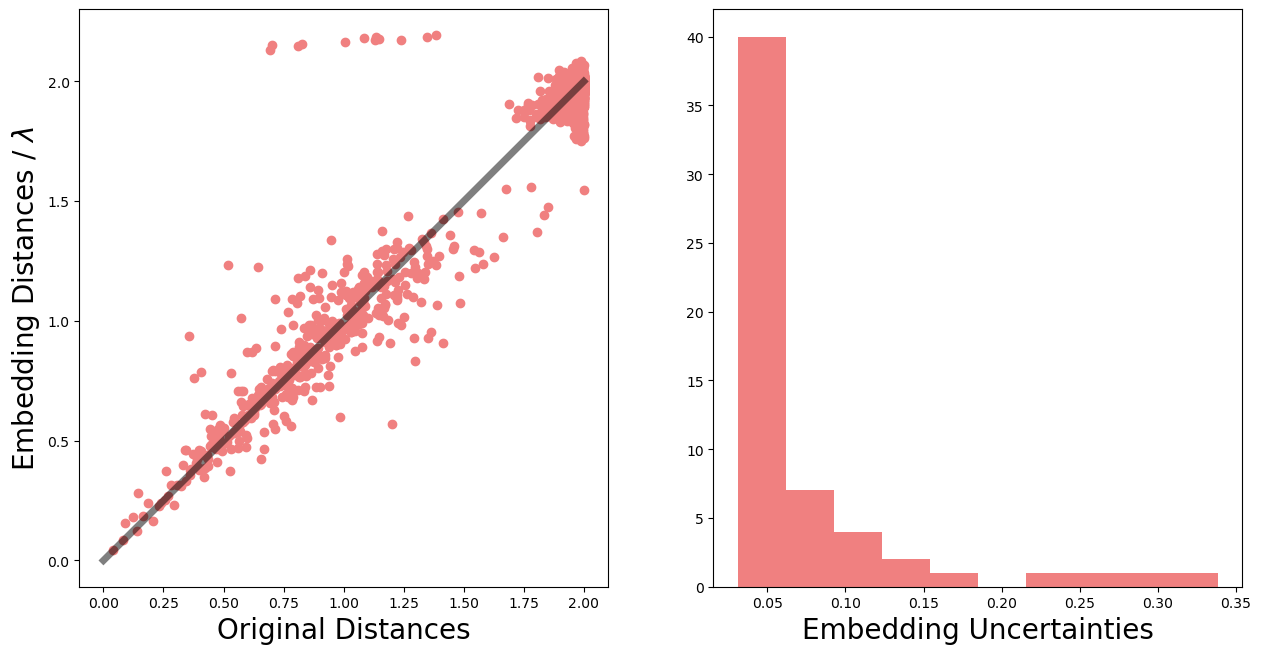

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(distance_matrix_squaredp.values[np.triu_indices(58, k=1)], hyp_emb['emb_mat'][np.triu_indices(58, k=1)], c='lightcoral') #cornflowerblue, lightcoral
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb['sig'], color ='lightcoral') #cornflowerblue, lightcoral
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)

In [28]:
hyperbolic_df= pd.DataFrame(hyp_emb['pcoords'], columns=['x', 'y', 'z'])



In [29]:
%store -r clust_labs_AVA_RME_stim1


In [30]:
clust_labs_AVA_RME_stim1 = np.array(clust_labs_AVA_RME_stim1)

In [31]:
clust_labs_AVA_RME_stim1 = clust_labs_AVA_RME_stim1[:, np.newaxis]


In [32]:
clust_labs_AVA_RME_stim1

array([['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['AVA'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['RME'],
       ['AVA'],
       ['AVA'],
       ['AVA']], dtype='<U3')

In [33]:
hyperbolic_df['clusters'] = clust_labs_AVA_RME_stim1

In [34]:
hyperbolic_df

,x,y,z,clusters
0,0.235535,-0.712744,0.589421,RME
1,0.208975,-0.767925,0.526192,RME
2,0.291998,-0.669814,0.612439,RME
3,0.357153,-0.739968,0.493124,RME
4,0.278304,-0.675583,0.612221,RME
5,0.103625,-0.884813,0.355345,RME
6,0.180624,-0.870899,0.363942,RME
7,0.297530,-0.716054,0.558931,RME
8,0.350773,-0.739884,0.496377,RME
9,0.246078,-0.757072,0.531374,RME


In [38]:


# Create a scatter plot
fig = px.scatter_3d(data_frame = hyperbolic_df, x= 'x', y = 'y', z= 'z', title='Stim1 AVA and RME Bacterial Stimulus',  color ='clusters', color_discrete_map={'RME': 'blue', 'AVA': 'red'}) #cornflowerblue, lightcoral
fig.update_layout(
    scene=dict(
        xaxis=dict(ticktext=[-1, -0.5, 0, 0.5, 1]),
        yaxis=dict(ticktext=[-1, -0.5, 0, 0.5, 1]),
        zaxis=dict(ticktext=[-1, -0.5, 0, 0.5, 1]),
    )
)

fig.show()

# Fitting For Dimension

Suppose we did not know a-priori that the data was 5D? This is usually the case

## Fit the model across a range of dimensions

In [84]:
all_fits = []
for d in np.arange(2,15):
    dat={'N':58, 'D':d , 'deltaij':distance_matrix_squaredp}
    #run optimizer
    model = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e-2)
    all_fits.append({'euc':model.euc, 'sig':model.sig, 'lambda':model.stan_variable('lambda'), 't':model.time})

20:19:05 - cmdstanpy - INFO - Chain [1] start processing
20:19:25 - cmdstanpy - INFO - Chain [1] done processing
20:19:25 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
20:19:25 - cmdstanpy - INFO - Chain [1] start processing
20:19:32 - cmdstanpy - INFO - Chain [1] done processing
20:19:32 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
20:19:32 - cmdstanpy - INFO - Chain [1] start processing
20:19:34 - cmdstanpy - INFO - Chain [1] done processing
20:19:34 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.
20:19:34 - cmdstanpy - INFO - Chain [1] start processing
20:19:38 - cmdstanpy - INFO - Chain [1] done processing
20:19:38 - cmdsta

In [85]:
model.stan_variable('lambda')

20:20:28 - cmdstanpy - WARNING - The default behavior of CmdStanMLE.stan_variable() will change in a future release to always return a numpy.ndarray, even for scalar variables.


0.902937

In [ ]:
#access the correct iteration 
iteration = all_fits[6]['t']


iteration

In [ ]:
model.time.shape

In [39]:
#calculate radii based on time parameter
radii = np.arccosh(iteration)

NameError: name 'iteration' is not defined

In [ ]:
radii

NameError: name 'radii' is not defined

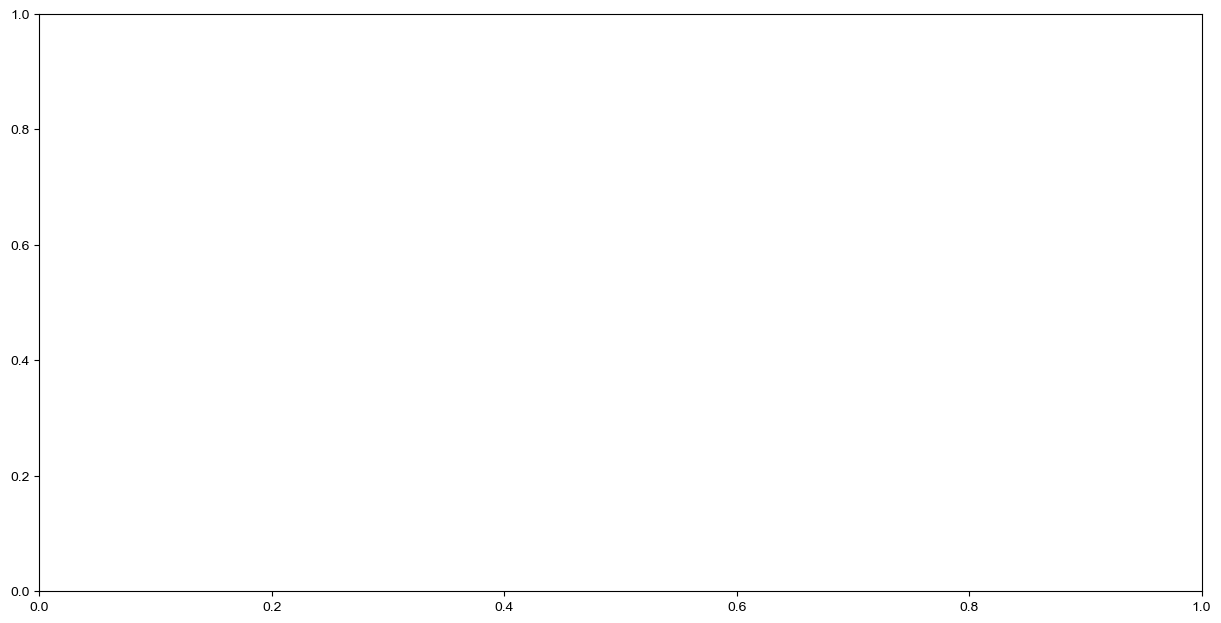

In [77]:
#Histogram of radii
fig, ax = plt.subplots(figsize=(15,7.5))

ax.hist(radii, color ='lightcoral') #cornflowerblue, lightcoral
ax.set_xlabel('Hyperbolic Embedding Radii', fontsize=20)

In [ ]:
#DIP analysis of radii
dip, pval = diptest.diptest(radii)

In [ ]:
dip, pval

In [86]:
#return negative log likelihood of fit
def MDS_lkl(fit, dmat):
    lkl = 0;
    N = fit['sig'].shape[0]
    
    sigs = fit['sig']
    lam = fit['lambda']
    emb_mat = get_embed_dmat(fit)
    
    for i in np.arange(N):
        for j in np.arange(i+1, N):
            seff = sigs[i]**2 + sigs[j]**2
            lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
    return lkl

#input: optimization fit and distance matrix
def BIC(fit, dmat):
    N,D = fit['euc'].shape
    n = 0.5*N*(N-1)
    k = N*D + N + 1.0 - 0.5*D*(D-1)
    
    return k*np.log(n) + 2.0*MDS_lkl(fit, dmat)





## Bayesian information criteria

There is a lot of formal Bayesian Theory behind this (see chapter 2 here https://urldefense.proofpoint.com/v2/url?u=https-3A__www.inference.org.uk_mackay_thesis.pdf&d=DwIGAg&c=-35OiAkTchMrZOngvJPOeA&r=B8GeUuyHfxQP8MseZuhipQ&m=KVww4gh9-XOtp1LqNUc0K-PGXOX3bm2QsokPFlBG9Vs&s=UBtNEdIXatq_zFpG53nmPCLbCnlgIgWigHYhEnBRYyo&e= ), but essentially we are trying to find the minimal number of parameters to describe a dataset. If the data is 5D, we don't want to use 7 parameters to describe it. The BIC is like a cost function that rewards a model that has a better fit to the likelihood function, but penalizes models that increase the number of their parameters. The model which minimizes this function will thus have the ideal trade-off of being able to model the data well without introducing too many parameters and overfitting the data.

In [87]:
all_BIC = [BIC(fit, distance_matrix_squaredp) for fit in all_fits]


In [88]:
print(distance_matrix_squaredp.index)

RangeIndex(start=0, stop=58, step=1)


In [89]:
all_BIC

[580.8612817444922,
 -2934.0207442640312,
 -3098.0635381713173,
 -3106.9787827171313,
 -3134.43959282534,
 -2986.310697618953,
 -2798.6577540081717,
 -2611.1546443258917,
 -2386.716059585221,
 -2123.3928619021126,
 -1859.9571446835698,
 -1607.2573066144641,
 -1376.848431246307]

As you can see the BIC is minimized at the true dimension of 5. Any more parameters would have been redundant, any less would not have properly fit the data

Text(0, 0.5, 'BIC')

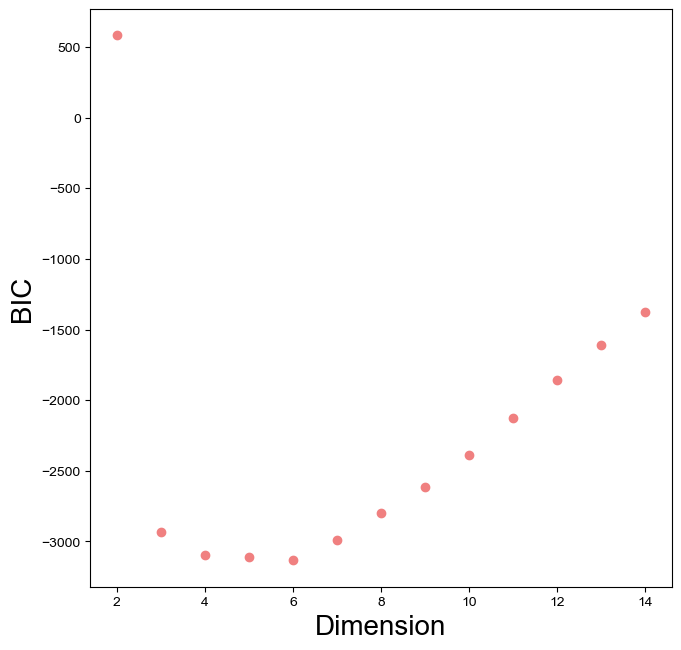

In [90]:
fig, ax = plt.subplots(figsize=(7.5,7.5))

ax.scatter(np.arange(2,15), all_BIC, c = 'lightcoral') #cornflowerblue, lightcoral
ax.set_xlabel('Dimension', fontsize=20)
ax.set_ylabel('BIC', fontsize=20)

# Re-Running the optimizer
Lets start by generating some 2D data

In [ ]:
#generate 100 data points uniformly distributed in 5 dimensional hyperbolic space of radius R=4
dim=2; R=4.0;
n=100
dirs = stats.norm.rvs(size=(n, dim))
dirs = (dirs.T/np.sqrt(np.sum(np.square(dirs), axis=1))).T
U = stats.uniform.rvs(size=n)
rs_p = np.tanh(np.log((1-np.exp(-R))/np.exp(-R)*(U) + 1.0)/2.0)
p_coords = rs_p.reshape(-1,1)*dirs

#add noise to the computed distance matrix to simulate a more realistic dataset
mat_2D = get_dmat(p_coords) + 0.05*R*stats.norm.rvs(size=(n,n))
for i in np.arange(n):
    for j in np.arange(i+1, n):
        mat_2D[j][i] = mat_2D[i][j]
mat_2D = 2.0*mat_2D/np.max(mat_2D)

In [ ]:
#dictionary to specify input to simulation
dat={'N':100, 'D':2, 'deltaij':mat_2D}
#run optimizer
model2D = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2)
hyp_emb2D = {'euc':model2D.euc, 'sig':model2D.sig, 'lambda':model2D.stan_variable('lambda')}

In [ ]:
process_sim(hyp_emb2D)

#### Most pts are well fit, but a few are poorly fit (the ones with high sigma) which adds a lot of scatter to the shepard diagram
#### The optimizer got caught in a false minimum

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(mat_2D[np.triu_indices(100, k=1)], hyp_emb2D['emb_mat'][np.triu_indices(100, k=1)])
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb2D['sig'])
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)

### Strategy: randomize the positions of the poorly fit points, and then return the coordinates as the initial conditions to continue optimizing. This bumps the simulation out of the false minimium without destroying all of the work its already done

In [ ]:
#figure out which pts have high uncertainty, and randomize their coordinates without touching the rest of the points
N_refit = np.where(hyp_emb2D['sig'] > 0.3)[0].shape[0]
hyp_emb2D['euc'][np.where(hyp_emb2D['sig'] > 0.3)] = stats.norm.rvs(size=(N_refit,2))

In [ ]:
#re-reun the optimizer, but this time sepcify the initial condition by passing the previous simulation dictionary
dat={'N':100, 'D':2, 'deltaij':mat_2D}
model2D = ltz_m.optimize(data=dat, iter=250000, algorithm='LBFGS', tol_rel_grad=1e2,inits = hyp_emb2D)
hyp_emb2D = {'euc':model2D.euc, 'sig':model2D.sig, 'lambda':model2D.stan_variable('lambda')}
# tst_2D = ltz_m.optimizing(data=dat, iter=250000, tol_rel_grad=1e2, init=tst_2D)

In [ ]:
process_sim(hyp_emb2D)

### We see that the fit is significantly better, although there are still a few poorly fit points. We could keep iterating the above process until all points are well fit.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,7.5))

ax[0].scatter(mat_2D[np.triu_indices(100, k=1)], hyp_emb2D['emb_mat'][np.triu_indices(100, k=1)])
ax[0].plot(np.arange(3), np.arange(3), c='black', linewidth=5, alpha=0.5)

ax[0].set_xlabel('Original Distances', fontsize=20)
ax[0].set_ylabel('Embedding Distances / $\lambda$', fontsize=20)

ax[1].hist(hyp_emb2D['sig'])
ax[1].set_xlabel('Embedding Uncertainties', fontsize=20)